In [2]:
# Sadece gerekli kütüphaneler içe aktarılıyor (GÜNCELLENDİ)
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler # Veri Ölçekleme için eklendi
from sklearn.feature_selection import RFE # Özyinelemeli Özellik Elemesi (RFE) için eklendi
import matplotlib.pyplot as plt
import seaborn as sns # Confusion Matrix görselleştirmesi

# Dosya Adları 
X_train_file = 'X_train.csv'
X_test_file = 'X_test.csv'
y_train_file = 'y_train.csv'
y_test_file = 'y_test.csv'

# Veri setlerini yükleme
X_train = pd.read_csv(X_train_file)
X_test = pd.read_csv(X_test_file)
# y etiketlerini tek boyutlu hale getirme
y_train = pd.read_csv(y_train_file)['target'].values.ravel()
y_test = pd.read_csv(y_test_file)['target'].values.ravel()

In [3]:
# ----------------------------------------------------
# ÖN İŞLEME ADIMLARI: Ölçekleme ve RFE ile Özellik Seçimi
# ----------------------------------------------------

# 1. Veri Ölçekleme (StandardScaler) 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ölçeklenmiş verileri DataFrame'e dönüştürme (Özellik isimlerini korumak için)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 2. Özyinelemeli Özellik Elemesi (RFE) ile Özellik Seçimi
# RFE'de en iyi özellik sayısı modelin (estimator) performansı ile dolaylı olarak belirlenir.

# Temel Model olarak LDA kullanılıyor (doğrusal modeller RFE için iyidir)
estimator = LinearDiscriminantAnalysis() 

# RFE nesnesini oluşturma
# n_features_to_select belirtilmezse, varsayılan olarak (özellik_sayısı / 2) seçilir. 
# Açıklık için 5 seçilmiştir. RFECV ise optimal k değerini bulur.
rfe_selector = RFE(estimator=estimator, n_features_to_select=5, step=1) 

# Seçimi sadece eğitim verisi üzerinde fit etme ve veriyi dönüştürme
rfe_selector.fit(X_train_scaled_df, y_train)

X_train_final = rfe_selector.transform(X_train_scaled_df)
X_test_final = rfe_selector.transform(X_test_scaled_df)

# Seçilen özelliklerin isimlerini alma
selected_features = X_train.columns[rfe_selector.support_].tolist()
k_final = len(selected_features)

print(f"RFE ile Seçilen En İyi {k_final} Özellikler: {selected_features}")
print("Modeller artık seçilmiş ve ölçeklenmiş veriyi (X_train_final) kullanacak.")

RFE ile Seçilen En İyi 5 Özellikler: ['number_inpatient', 'discharge_disposition_id_3', 'discharge_disposition_id_5', 'discharge_disposition_id_11', 'discharge_disposition_id_22']
Modeller artık seçilmiş ve ölçeklenmiş veriyi (X_train_final) kullanacak.


In [4]:
# Sonuçları depolamak için boş liste
results = []
# Tahminleri ve Olasılıkları depolayacak sözlükler
y_preds = {} 
y_probas = {} # ROC Eğrisi için

def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    """ Modeli eğiten, değerlendiren, sonuçları ve olasılıkları kaydeden fonksiyon."""

    # Modeli Eğitme
    model.fit(X_train, y_train)

    # Tahmin yapma
    y_pred = model.predict(X_test)
 
    # Olasılık tahmini yapma (ROC Eğrisi için)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = None 

    y_preds[model_name] = y_pred # Confusion Matrix için tahminleri kaydet
    y_probas[model_name] = y_proba # ROC Eğrisi için olasılıkları kaydet

 # Metrikleri hesaplama
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

   # Sonuçları listeye kaydetme
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall
    })

    print(f"\n--- {model_name} Sonuçları ---")
    print(f"Doğruluk (Accuracy): {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return model



In [5]:
# 1. SGDClassifier (Varsayılan L2 - Ridge)
sgd_model = SGDClassifier(loss='log_loss',
                          penalty='l2',
                          alpha=0.0001,
                          max_iter=1000,
                          tol=1e-3,
                          random_state=42)
train_and_evaluate(sgd_model, X_train_final, y_train, X_test_final, y_test, "SGDClassifier")


--- SGDClassifier Sonuçları ---
Doğruluk (Accuracy): 0.8868
F1-Score: 0.0619


SGDClassifier(loss='log_loss', random_state=42)

In [6]:
# Yeni Model: SGDClassifier_New (L1 - Lasso) (YENİ PARAMETRELER EKLENDİ)
sgd_model_new = SGDClassifier(loss='log_loss',
               penalty='l1', # L1 (Lasso) Regülarizasyonu
               alpha=0.001, # Regülarizasyon gücü
               max_iter=1000, 
               tol=1e-4,
               random_state=42)
train_and_evaluate(sgd_model_new, X_train_final, y_train, X_test_final, y_test, "SGDClassifier_New")


--- SGDClassifier_New Sonuçları ---
Doğruluk (Accuracy): 0.8882
F1-Score: 0.0257


SGDClassifier(alpha=0.001, loss='log_loss', penalty='l1', random_state=42,
              tol=0.0001)

In [7]:
# 2. LDA (Linear Discriminant Analysis)
lda_model = LinearDiscriminantAnalysis(solver='svd')
train_and_evaluate(lda_model, X_train_final, y_train, X_test_final, y_test, "LDA")




--- LDA Sonuçları ---
Doğruluk (Accuracy): 0.8865
F1-Score: 0.0648


LinearDiscriminantAnalysis()

In [8]:
# 2. LDA (Linear Discriminant Analysis)
# solver='lsqr' ve shrinkage='auto' ile kovaryans matrisi tahmini düzenlenir (Regularization).
# Bu, özellikle küçük veri setlerinde veya yüksek korelasyonlu verilerde LDA performansını artırabilir.
lda_model = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
train_and_evaluate(lda_model, X_train_final, y_train, X_test_final, y_test, "LDA")


--- LDA Sonuçları ---
Doğruluk (Accuracy): 0.8865
F1-Score: 0.0648


LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

In [9]:
# Sonuçları DataFrame'e dönüştürme
results_df = pd.DataFrame(results)
print("\n--- Model Karşılaştırma Tablosu ---")
print(results_df.round(4))


--- Model Karşılaştırma Tablosu ---
               Model  Accuracy  F1-Score  Precision  Recall
0      SGDClassifier    0.8868    0.0619     0.4130  0.0335
1  SGDClassifier_New    0.8882    0.0257     0.4688  0.0132
2                LDA    0.8865    0.0648     0.4000  0.0352
3                LDA    0.8865    0.0648     0.4000  0.0352



--- Karışıklık Matrisleri Oluşturuluyor ---


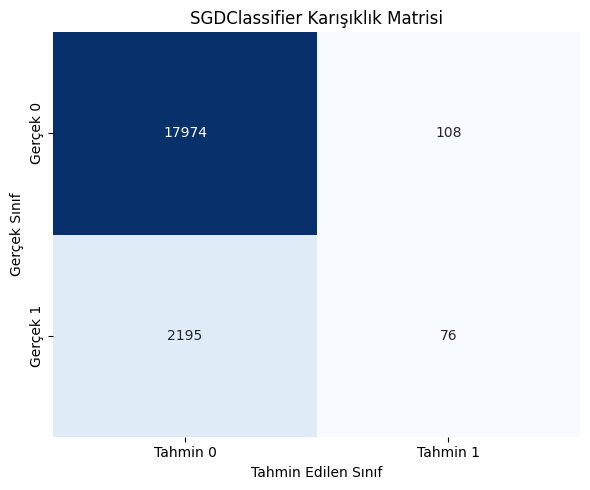

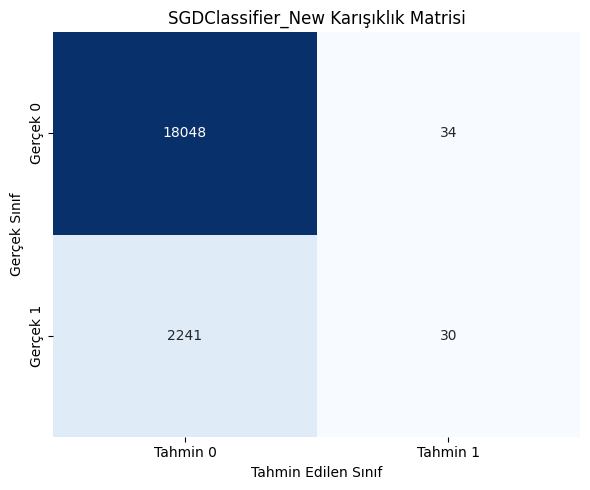

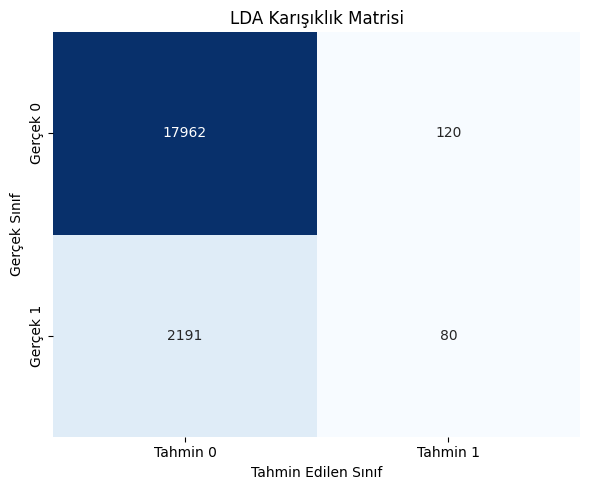

In [10]:
# CELL 4: Karışıklık Matrisleri
def plot_confusion_matrix(y_true, y_pred, model_name):
    """ Karışıklık Matrisini hesaplayıp görselleştiren fonksiyon."""
    cm = confusion_matrix(y_true, y_pred)
 
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Tahmin 0', 'Tahmin 1'],
                yticklabels=['Gerçek 0', 'Gerçek 1'])
    plt.title(f'{model_name} Karışıklık Matrisi')
    plt.ylabel('Gerçek Sınıf')
    plt.xlabel('Tahmin Edilen Sınıf')
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_cm.png')
    plt.show()

print("\n--- Karışıklık Matrisleri Oluşturuluyor ---")
plot_confusion_matrix(y_test, y_preds['SGDClassifier'], "SGDClassifier")
plot_confusion_matrix(y_test, y_preds['SGDClassifier_New'], "SGDClassifier_New")
plot_confusion_matrix(y_test, y_preds['LDA'], "LDA")

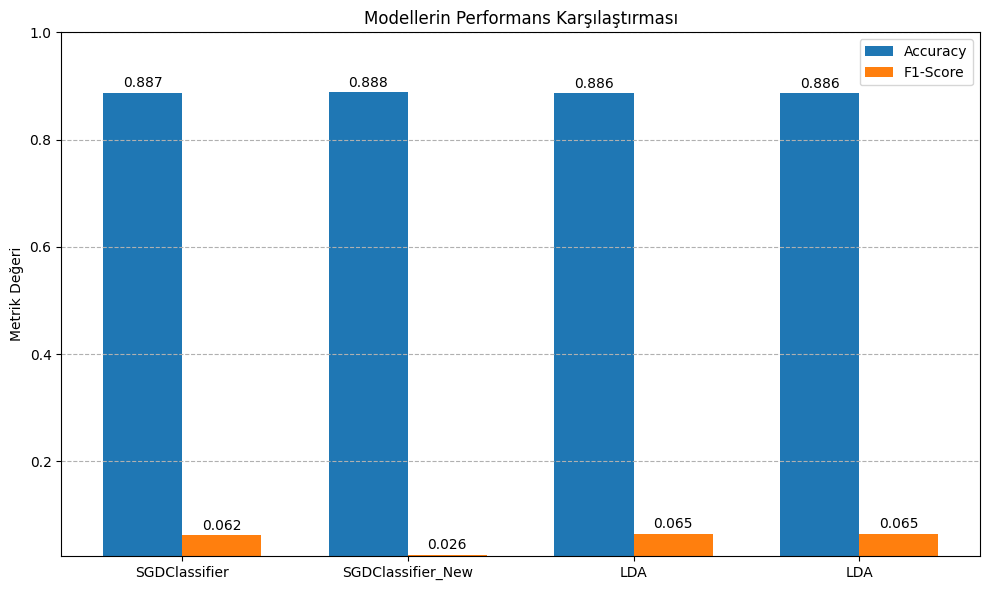


Karışıklık Matrisleri ve Metrik Karşılaştırma Grafiği kaydedildi.


In [11]:
# CELL 5: Metrik Karşılaştırma Grafiği 
metrics_to_plot = ['Accuracy', 'F1-Score']
bar_width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))

x_pos = np.arange(len(results_df['Model']))

for i, metric in enumerate(metrics_to_plot):
     offset = bar_width * i - (bar_width / 2)
     bars = ax.bar(x_pos + offset, results_df[metric], bar_width, label=metric)

     for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Metrik Değeri')
ax.set_title('Modellerin Performans Karşılaştırması')
ax.set_xticks(x_pos)
ax.set_xticklabels(results_df['Model'], rotation=0)
ax.legend()
ax.set_ylim(bottom=results_df[metrics_to_plot].min().min() * 0.9, top=1.0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('model_metrik_karsilastirma.png')
plt.show()

print("\nKarışıklık Matrisleri ve Metrik Karşılaştırma Grafiği kaydedildi.")


SGDClassifier AUC: 0.6198
SGDClassifier_New AUC: 0.6563
LDA AUC: 0.6546


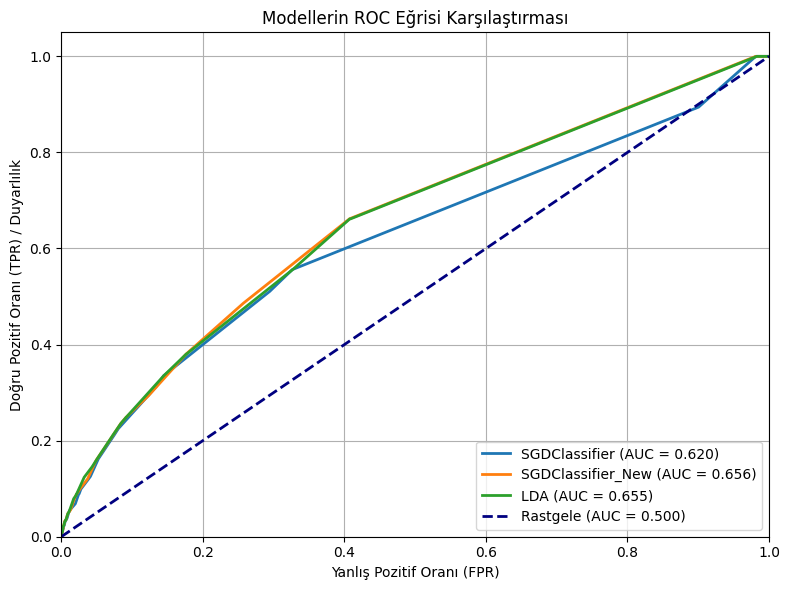


ROC Eğrisi karşılaştırma grafiği kaydedildi.


In [12]:
# CELL 6: ROC Eğrisi ve AUC Görselleştirmesi 
##  ROC Eğrisi Karşılaştırması ve AUC Hesaplaması
plt.figure(figsize=(8, 6))

models_to_plot = ["SGDClassifier", "SGDClassifier_New", "LDA"]

for model_name in models_to_plot:
    y_proba = y_probas.get(model_name)
    
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')
        print(f"{model_name} AUC: {roc_auc:.4f}")
    else:
        print(f"Uyarı: {model_name} için olasılık tahminleri (predict_proba) mevcut değil.")

# Rastgele Sınıflandırıcı (AUC = 0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Rastgele (AUC = 0.500)')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oranı (FPR)')
plt.ylabel('Doğru Pozitif Oranı (TPR) / Duyarlılık')
plt.title('Modellerin ROC Eğrisi Karşılaştırması')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig('modeller_roc_karsilastirma.png')
plt.show()
print("\nROC Eğrisi karşılaştırma grafiği kaydedildi.")